In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2024-07-15 16:38:31.225756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 16:38:31.413284: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 16:38:31.474039: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 16:38:31.504504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 16:38:31.552712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [2]:
scale_size = 6
HR_SIZE = (1200, 1200)
LR_SIZE = (HR_SIZE[0] // scale_size, HR_SIZE[1] // scale_size)
patch_size = 10  
stride = 5  
dataset, info = tfds.load('div2k', split='train', with_info=True)

In [3]:
def norm(img):
    img = tf.cast(img['hr'], tf.float32)
    img = img / 255.0
    return img

def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    lr_image = tf.image.resize(input, [input_size, input_size], method="area")
    return lr_image

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    hr_image = tf.image.resize(input, HR_SIZE, method='bilinear')
    return hr_image

def preprocess_image(data):
    hr_image = process_target(data)
    lr_image = process_input(data, LR_SIZE[0], scale_size)
    return lr_image, hr_image

In [4]:
def create_patches(image, patch_size, stride):
    print("Input shape to create_patches:", tf.shape(image))
    height = image.shape[1]
    if len(image.shape) == 2 and image.shape[1] == 3:
        image = tf.reshape(image, (10, 10, 3))  
    elif len(image.shape) == 3:
        image = tf.expand_dims(image, 0)
    
    print("Adjusted input shape:", tf.shape(image))
    
    patches = tf.image.extract_patches(
        images=image,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, stride, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )
    patches = tf.reshape(patches, [-1, patch_size, patch_size, tf.shape(image)[-1]])
    return patches

def reassemble_patches(patches, original_shape, patch_size, stride):
    height, width, channels = original_shape
    num_patches_h = (height // scale_size - patch_size) // stride + 1
    num_patches_w = (width // scale_size - patch_size) // stride + 1
    
    patches = tf.reshape(patches, [num_patches_h, num_patches_w, patch_size, patch_size, channels])
    
    reconstructed = tf.zeros(original_shape)
    count = tf.zeros(original_shape)
    
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            h_start = i * stride * scale_size
            w_start = j * stride * scale_size
            patch = patches[i, j]
            
            reconstructed = tf.tensor_scatter_nd_add(
                reconstructed,
                tf.constant([[h_start, w_start]]),
                tf.expand_dims(patch, 0)
            )
            count = tf.tensor_scatter_nd_add(
                count,
                tf.constant([[h_start, w_start]]),
                tf.ones_like(tf.expand_dims(patch, 0))
            )
    
    reconstructed = tf.where(count > 0, reconstructed / count, reconstructed)
    
    return reconstructed

def patch_dataset(dataset, patch_size, stride):
    def process_sample(lr, hr):
        lr_patches = create_patches(lr, patch_size, stride)
        hr_patches = create_patches(hr, patch_size * scale_size, stride * scale_size)
        return lr_patches, hr_patches
    
    patched_dataset = dataset.map(process_sample)
    patched_dataset = patched_dataset.unbatch()
    return patched_dataset



In [5]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

class DepthToSpace(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

def leaky_relu_activation(x):
    leaky_relu_out = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    linear_out = x
    return leaky_relu_out + linear_out

class SinglePixelAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SinglePixelAttention, self).__init__(**kwargs)
        
    def call(self, inputs):
        mean_values = tf.reduce_mean(inputs, axis=-1)
        max_indices = tf.argmax(mean_values, axis=-1)
        attention_mask = tf.one_hot(max_indices, depth=tf.shape(inputs)[1])
        attention_mask = tf.expand_dims(attention_mask, axis=-1)
        attention_output = inputs * attention_mask
        return attention_output

In [6]:
def build_espcn_model_with_skip_connections(input_shape, scale_size):
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(16, 5, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv2 = tf.keras.layers.Conv2D(16, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(conv1)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)
    skip1 = tf.keras.layers.Add()([conv1, conv2])
    conv3 = tf.keras.layers.Conv2D(16, 2, padding='same', kernel_initializer='orthogonal')(skip1)
    conv3 = tf.keras.layers.Lambda(leaky_relu_activation)(conv3)
    conv3 = SinglePixelAttention()(conv3)
    skip2 = tf.keras.layers.Add()([skip1, conv3])
    conv4 = tf.keras.layers.Conv2D(3 * (scale_size ** 2), 3, padding='same', kernel_initializer='orthogonal')(skip2)
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv4)
    outputs = DepthToSpace(scale_size)(conv4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [7]:
dataset = dataset.map(norm)
dataset = dataset.map(preprocess_image)
patched_dataset = patch_dataset(dataset, patch_size, stride)
patched_dataset = patched_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

input_shape = (patch_size, patch_size, 3)
espcn_model_with_skip_and_attention = build_espcn_model_with_skip_connections(input_shape, scale_size)
espcn_model_with_skip_and_attention.compile(optimizer='adam', loss='mse', metrics=[psnr])

espcn_model_with_skip_and_attention.summary()

Input shape to create_patches: Tensor("Shape:0", shape=(3,), dtype=int32)
Adjusted input shape: Tensor("Shape_1:0", shape=(4,), dtype=int32)
Input shape to create_patches: Tensor("Shape_3:0", shape=(3,), dtype=int32)
Adjusted input shape: Tensor("Shape_4:0", shape=(4,), dtype=int32)


/home/ucaa6ee40bd77d32843530d16ad70bd6/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 10, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 10, 10,    │      1,216 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 10, 10,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 10, 10,    │      2,320 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 10, 10,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 10,    │          0 │ leaky_re_lu[0][0… │
│                     │ 16)               │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10,    │      1,040 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 10, 10,    │          0 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ single_pixel_atten… │ (None, 10, 10,    │          0 │ lambda[0][0]      │
│ (SinglePixelAttent… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 10,    │          0 │ add[0][0],        │
│                     │ 16)               │            │ single_pixel_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     15,660 │ add_1[0][0]       │
│                     │ 108)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 10, 10,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 108)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depth_to_space      │ (None, 60, 60, 3) │          0 │ leaky_re_lu_3[0]… │
│ (DepthToSpace)      │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,236 (79.05 KB)

 Trainable params: 20,236 (79.05 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
espcn_model_with_skip_and_attention.fit(patched_dataset, epochs=7)


Epoch 1/7


2024-07-15 16:38:50.049035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/functional_1/leaky_re_lu_3_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/functional_1/conv2d_3_1/add'.


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 882s 22ms/step - loss: 0.0030 - psnr: 29.6537
Epoch 2/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 879s 22ms/step - loss: 0.0018 - psnr: 32.2173
Epoch 3/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 937s 23ms/step - loss: 0.0017 - psnr: 32.3542
Epoch 4/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1045s 26ms/step - loss: 0.0017 - psnr: 32.3964
Epoch 5/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1102s 28ms/step - loss: 0.0017 - psnr: 32.4283
Epoch 6/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1039s 26ms/step - loss: 0.0017 - psnr: 32.4473
Epoch 7/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1103s 28ms/step - loss: 0.0017 - psnr: 32.4838


In [9]:
# espcn_model_with_skip_and_attention.save("espcn_model.h5")

In [10]:
img_dir = 'lr_image_resized.png'

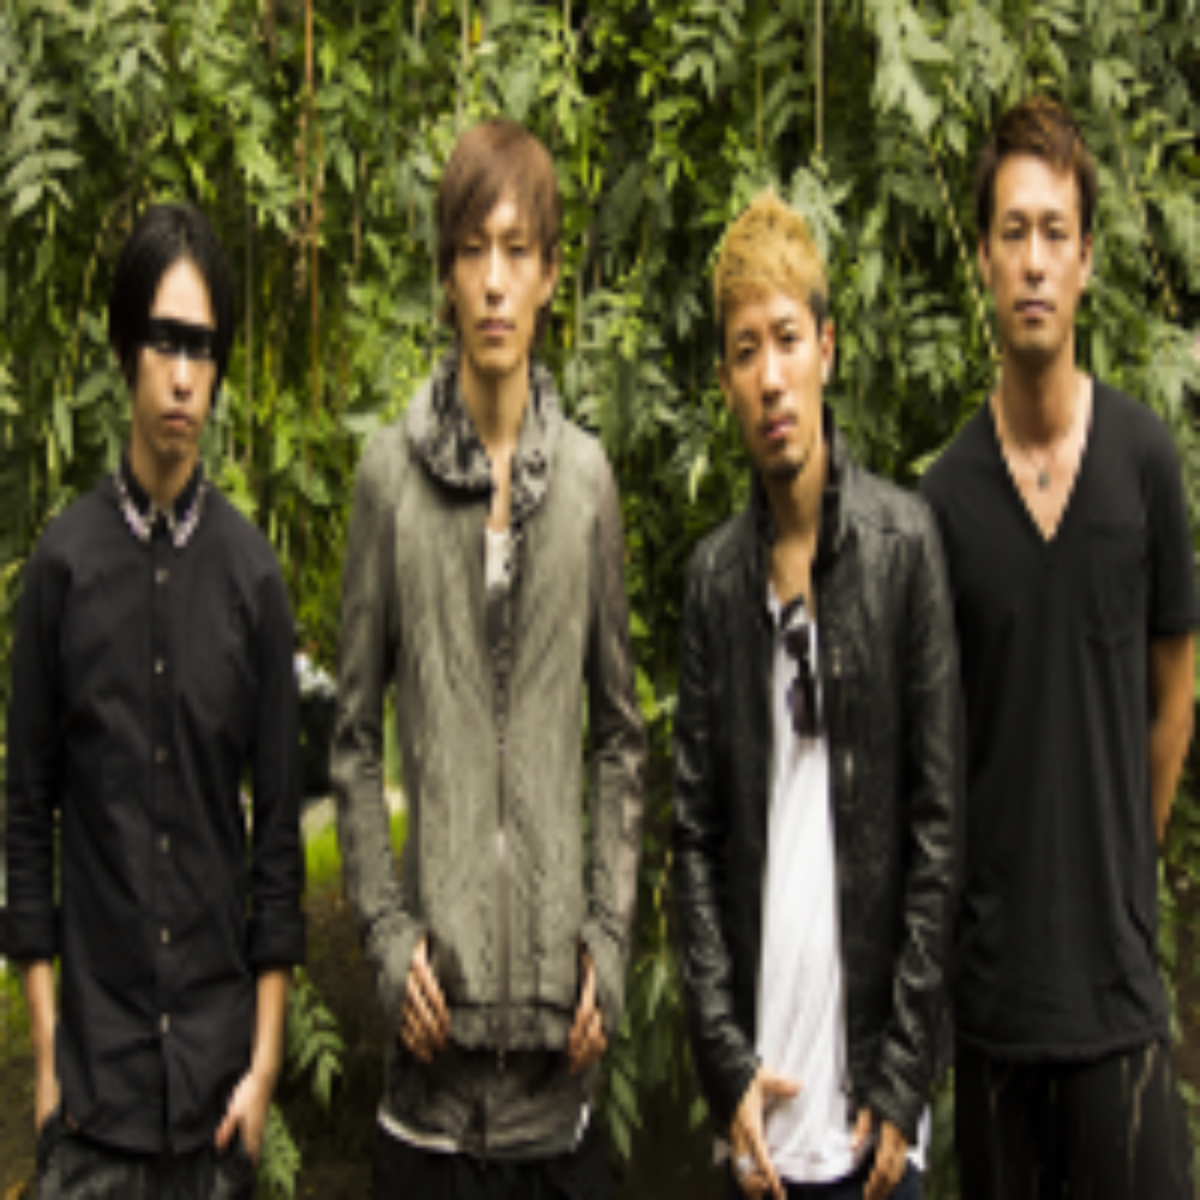

In [11]:
from PIL import Image
image = Image.open(img_dir)
image.show()

In [12]:
lr = tf.cast(image,tf.float32)
img = lr/255.0

In [13]:
img.shape

TensorShape([1200, 1200, 4])

In [14]:
test_height = img.shape[1]/6 
test_width = img.shape[2]/6
print(test_height)
img = tf.image.resize(img, (200,200))

200.0


In [20]:
lr_patch = create_patches(img,10,5)

Input shape to create_patches: tf.Tensor([200 200   4], shape=(3,), dtype=int32)
Adjusted input shape: tf.Tensor([  1 200 200   4], shape=(4,), dtype=int32)


In [21]:
def rgba_to_rgb(input, name=None):
    rgba = tf.unstack(input, axis=-1)
    r, g, b, a = rgba[0], rgba[1], rgba[2], rgba[3]
    return tf.stack([r, g, b], axis=-1)

In [22]:
lr_patch = rgba_to_rgb(lr_patch)

In [23]:
print(lr_patch.shape)

(800, 10, 10, 3)


In [24]:
out = espcn_model_with_skip_and_attention.predict(lr_patch)

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2024-07-15 18:40:45.712648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'functional_1/lambda_1/add' exist for missing node 'functional_1/conv2d_2_1/add'.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [25]:
out.shape

(800, 60, 60, 3)

In [26]:
empt = []
for val in range(len(out)):
    if val%2 == 0:
      empt.append(out[val])

In [27]:
img = np.asarray(empt)
print(img.shape)

(400, 60, 60, 3)


In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
tensor = tf.constant(img)

In [30]:
reshaped_img = tf.reshape(tensor, (20, 20, 60, 60, 3))

In [31]:
rearranged = tf.transpose(reshaped_img,perm=[0, 2, 1, 3, 4])

In [32]:
final = tf.reshape(rearranged,(20 * 60, 20 * 60, 3))

In [33]:
final.shape

TensorShape([1200, 1200, 3])

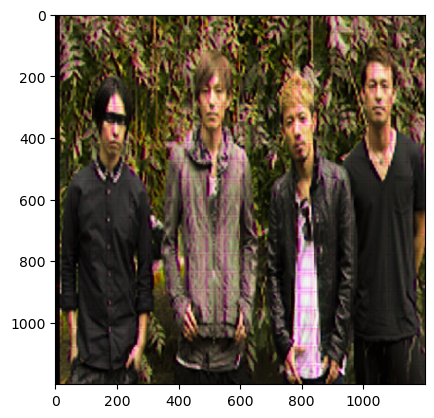

In [34]:
plt.imshow(final)